# Final Project BDA 511 -- Zach Duff

----
---

## **1. Data Preparation**

---

The first thing we need to do is find a good way to read our housing data, so that we can make use of it. So let's import the Python tools we'll be using (also the math ones used later on):

In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn

a4_dims = (11.7, 8.27)

import warnings
warnings.filterwarnings("ignore") # Annoyed by deprecation warnings.


We'll use ```pandas``` to grab the data from the csv files and place them into pandas dataframes.

In [30]:
train_file = "train_data.csv"
test_file = "test_data.csv"

# pandas dataframes
df_train = pd.read_csv(train_file, header=0)
df_test = pd.read_csv(test_file, header=0)

Below is an example of the ```pandas``` dataframe structure.

In [31]:
df_train[:10] #First 10 rows of our training data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


It's now clear that we have both numerical and non numerical data. We can display data type in each column of our data with ```pandas.dtypes```.

In [32]:
df_train.dtypes[:10]

Id               int64
MSSubClass       int64
MSZoning        object
LotFrontage    float64
LotArea          int64
Street          object
Alley           object
LotShape        object
LandContour     object
Utilities       object
dtype: object

Or more specifically:

In [33]:
df_train.get_dtype_counts()

float64     3
int64      35
object     43
dtype: int64

We'll need different of models for these different data types. Also, we can see that some of our features contain values of ```NaN```. These ```NaN```'s were converted, via ```pandas``` from missing data (_NA_'s) in our csv file, so we'll have to be wary of that as well.

### **1.1 A Quick Look at the Target Variable**
---

Since our main objective is predict housing price data, let's take a look at housing prices alone. After all, a simple average _is_ a crude predictor.

In [70]:
# Dependent Variables

from matplotlib.ticker import FormatStrFormatter

y_train = df_train.SalePrice.values #pd --> np
y_train = y_train.reshape(len(y_train), 1) # To be overwritten to match cleansed data later on.
avg_train = y_train.mean()
y_var = df_train.std().SalePrice
fig, ax = pyplot.subplots(figsize=a4_dims)
ax = sns.distplot(ax=adf_train['SalePrice'], size=(20., 15.));
ax.xaxis.set_major_formatter(FormatStrFormatter('$%d'))
ax.locator_params(nbins=4)

print("Number of Training Samples: %s" % len(y_train))
print("Average Training House Price: " + "${:,.2f}".format(avg_train) + '\n')


SyntaxError: positional argument follows keyword argument (<ipython-input-70-a050c7e5f188>, line 10)

With the average training house price in hand we can make an informed prediction about the values of our test data. If we predict that a test house chosen at random from our test data is $\bar{y} = 180,921$ we can measure how wrong we were using the root mean square error (aka RMSE):

$$E_0 = \sqrt{\sum_{i=0}^{1459}\left(y^i - \bar{y} \right)^2}$$

Implemented in python:

In [15]:
E0 = np.sum([np.sqrt((avg_train - y) ** 2) for y in y_train])
print("Error = %.2e" % E0 + '\n')

Error = 8.39e+07



This doesn't really tell us much except that our error is huge. Instead we can take the Mean Absolute Error to see exactly how wrong we were on average.

In [17]:
mae = np.sum([abs(avg_train - y) for y in y_train]) / 1459.
print("Mean Absolute Error: " + "${:,.2f}".format(mae) + '\n')

Mean Absolute Error: $57,474.14



So, we were off by about \\$12,000 on average. Let's move on to more sophisticated methods to see if we can improve our score.

### **1.2. Data Cleansing**

Before we train our model, we'll spend some time to clean up our training data. We'll decide which dimensions are going to be most useful (since there's 80 of them) in the prediction of housing price. As mentioned earlier, we noticed that some of our variables included categorical data, so for now, we'll ignore those dimension and look at stuff that has numerical data only. We'll also drop the MSSubclass feature, since even though it's entries are numbers, those numbers are actually classification types.

In order to accomplis this we'll use ```pandas``` to filter our data. 

In [9]:
# Get Numeric Features (not necessarily useful)
df_train_num = df_train.select_dtypes(include=['float64', 'int64'])

df_train_num = df_train_num.drop(labels=['MSSubClass', 'Id', 'SalePrice'], axis=1)

In [10]:
df_train_num[:10]

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,65.0,8450,7,5,2003,2003,196.0,706,0,150,...,548,0,61,0,0,0,0,0,2,2008
1,80.0,9600,6,8,1976,1976,0.0,978,0,284,...,460,298,0,0,0,0,0,0,5,2007
2,68.0,11250,7,5,2001,2002,162.0,486,0,434,...,608,0,42,0,0,0,0,0,9,2008
3,60.0,9550,7,5,1915,1970,0.0,216,0,540,...,642,0,35,272,0,0,0,0,2,2006
4,84.0,14260,8,5,2000,2000,350.0,655,0,490,...,836,192,84,0,0,0,0,0,12,2008
5,85.0,14115,5,5,1993,1995,0.0,732,0,64,...,480,40,30,0,320,0,0,700,10,2009
6,75.0,10084,8,5,2004,2005,186.0,1369,0,317,...,636,255,57,0,0,0,0,0,8,2007
7,NaN,10382,7,6,1973,1973,240.0,859,32,216,...,484,235,204,228,0,0,0,350,11,2009
8,51.0,6120,7,5,1931,1950,0.0,0,0,952,...,468,90,0,205,0,0,0,0,4,2008
9,50.0,7420,5,6,1939,1950,0.0,851,0,140,...,205,0,4,0,0,0,0,0,1,2008


Lastly, let's remove all rows that contain ```NaN``` values. And at the same time

In [ ]:
df_train_num = df_train_num.dropna()
print("Dimensions of remaining (good) data: [%s, %s] \n" % (df_train_num.shape[0], df_train_num.shape[1]))

So now we have 35 numerical variables (not all continuous) with 1121 completed filled rows (entries for each variable). This is essentially a "pure" section of our training data. We have to be careful here though because a value of ```NaN``` might be included in one of these dimensions for our test data, so we'll need a way to handle that later on.  
  
### 2. Data Exploration

First, to get a feel for our data -- and for fun -- we'll visualize it with a histogram. Below is are the histograms of all of our 35 numerical predictors.

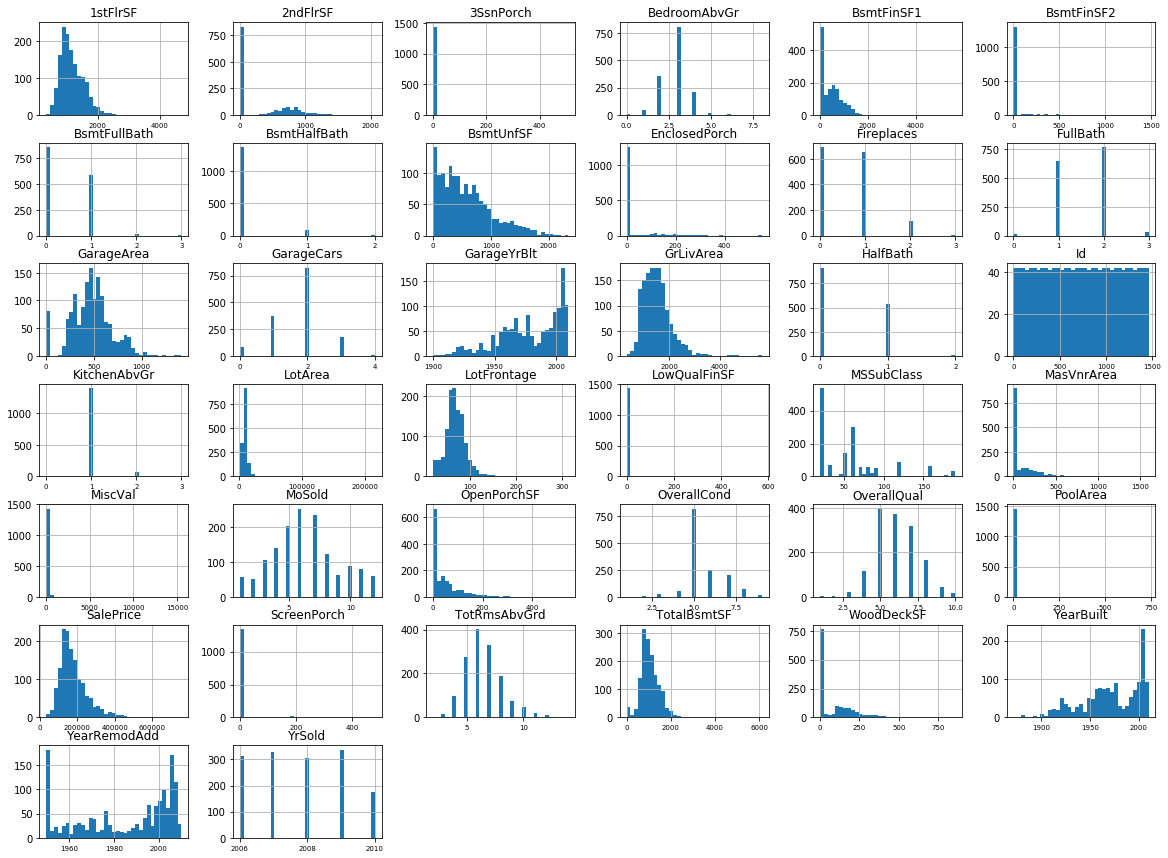

In [23]:
 figs = df_train.hist(bins=35, figsize=(20,15), xlabelsize=7) # colon suppresses printing metadat

Sort of what we, expected. We have a couple seemingly normal distributions in variables like _1stFlrSF_, which is first floor square footage; and we accidentally included our target variable _SalePrice_, which has already been noted as mostly normal.

---
---

Ultimately we'll want to predict housing price based on as little information as possible. That is, we aim to eliminate predictor variables that are strongly linearly correlated with others, thereby reducing our predictor dimensions into those that are unrelated, or are orthogonal. 

In order to achieve this we'll find the dimensions in our data that are most strongly correlated and discard the other. Below, we've built a heat map indicating which feature variables are strongly correlated. Blue is associated with negative correlation and red with positive correlation. [The correlation coeffcient used was Pearson's.](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html)

In [ ]:
corr = df_train_num.corr() # Pearson
fig = plt.figure()
fig.set_size_inches([20., 16.])
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df_train_num.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_train_num.columns)
ax.set_yticklabels(df_train_num.columns)
plt.show()

In the heatmap we note a few things:

* Anything correlated with itself has a correlation coefficient of 1. This information is of little value.
* The map is symmetric, as it should be.
* As suspected, strongly correlated items appear redundant. For example, the variables _GarageYrBlt_ and _YearBuilt_ have a strong correlation, and the square footage of finished basements in our test homes are negatively correlated with the squre footage of unfinished basements.

In light of these observations, we would like to choose dimensions for our model that do not appear to be strongly correlated (neutral grayish color). At the same time we want to select the uncorrelated variables that we believe apply to most homes.

In [ ]:
c = corr.abs().unstack()
c = c.sort_values(kind="quicksort")
c[:-34:2]

We don't want to use features that are highly correlated in potential models because the are essentially redundant. We want predictors to be independent. So we note that entries at the top of our correlation list are pair-wise good candidates for prediction of the target variable _salePrice_.

## Standardizing (Preprocessing)

In order to employ many machine learning algorithms our feature values have the same scale (source = Geron, p. 67). We'll use sklearn's preprocessing package.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler